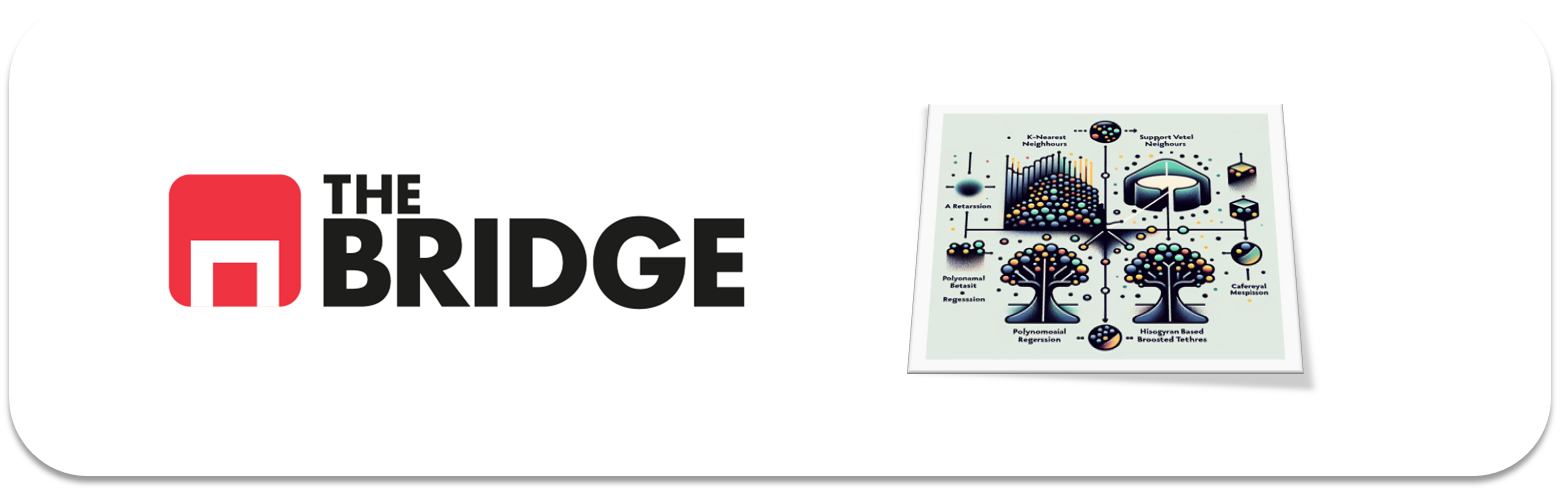

* La práctica consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [148]:
# Tratamiento de datos
import pandas as pd
import numpy as np
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, \
roc_curve, roc_auc_score, ConfusionMatrixDisplay, multilabel_confusion_matrix, mean_absolute_percentage_error, balanced_accuracy_score #MAPE para regresión, balanced_acc para CLASIFIC

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).  --> balanced_accuracy_score

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real. MÉTRICA (regresión) --> MAPE media abs error porcentual

NOTA: El dataset está limpio y sin valores faltantes.

CLASIFICACIÓN: TARGET --> QUALITY

REGRESSION: TARGET --> ALCOHOL 

In [50]:
df = pd.read_csv('.\datasets\wines_dataset.csv', sep='|')
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.5              0.21         0.26            9.25      0.034   
1               8.3              0.16         0.37            7.90      0.025   
2               6.8              0.18         0.38            1.40      0.038   
3               6.1              0.26         0.25            2.90      0.047   
4               7.5              0.63         0.27            2.00      0.083   
...             ...               ...          ...             ...        ...   
6492            7.7              0.39         0.34           10.00      0.056   
6493            8.2              0.73         0.21            1.70      0.074   
6494            7.4              0.31         0.48           14.20      0.042   
6495            8.3              0.65         0.10            2.90      0.089   
6496            8.4              0.67         0.19            2.20      0.093   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    73.0                 142.0  0.99450  3.05       0.37   
1                    38.0                 107.0  0.99306  2.93       0.37   
2                    35.0                 111.0  0.99180  3.32       0.59   
3                   289.0                 440.0  0.99314  3.44       0.64   
4                    17.0                  91.0  0.99616  3.26       0.58   
...                   ...                   ...      ...   ...        ...   
6492                 35.0                 178.0  0.99740  3.26       0.60   
6493                  5.0                  13.0  0.99680  3.20       0.52   
6494                 62.0                 204.0  0.99830  3.06       0.59   
6495                 17.0                  40.0  0.99803  3.29       0.55   
6496                 11.0                  75.0  0.99736  3.20       0.59   

      alcohol  quality  class  
0        11.4        6  white  
1        11.9        6  white  
2        11.2        7  white  
3        10.5        3  white  
4         9.8        6    red  
...       ...      ...    ...  
6492     10.2        5  white  
6493      9.5        5    red  
6494      9.4        5  white  
6495      9.5        5    red  
6496      9.2        4    red  

[6497 rows x 13 columns]

# PREVIO #

## 1.  PRIMER ANÁLISIS

### EDA ###

*LIMPIEZA*

No es necesaria, No hay NANs ni duplicados

In [51]:
print(df.shape)
print(df.info())
df.head()

(6497, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.5              0.21         0.26            9.25      0.034   
1            8.3              0.16         0.37            7.90      0.025   
2            6.8              0.18         0.38            1.40      0.038   
3            6.1              0.26         0.25            2.90      0.047   
4            7.5              0.63         0.27            2.00      0.083   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 73.0                 142.0  0.99450  3.05       0.37   
1                 38.0                 107.0  0.99306  2.93       0.37   
2                 35.0                 111.0  0.99180  3.32       0.59   
3                289.0                 440.0  0.99314  3.44       0.64   
4                 17.0                  91.0  0.99616  3.26       0.58   

   alcohol  quality  class  
0     11.4        6  white  
1     11.9        6  white  
2     11.2        7  white  
3     10.5        3  white  
4      9.8        6    red

In [52]:
df.describe().T

count        mean        std      min       25%  \
fixed acidity         6497.0    7.215307   1.296434  3.80000   6.40000   
volatile acidity      6497.0    0.339666   0.164636  0.08000   0.23000   
citric acid           6497.0    0.318633   0.145318  0.00000   0.25000   
residual sugar        6497.0    5.443235   4.757804  0.60000   1.80000   
chlorides             6497.0    0.056034   0.035034  0.00900   0.03800   
free sulfur dioxide   6497.0   30.525319  17.749400  1.00000  17.00000   
total sulfur dioxide  6497.0  115.744574  56.521855  6.00000  77.00000   
density               6497.0    0.994697   0.002999  0.98711   0.99234   
pH                    6497.0    3.218501   0.160787  2.72000   3.11000   
sulphates             6497.0    0.531268   0.148806  0.22000   0.43000   
alcohol               6497.0   10.491801   1.192712  8.00000   9.50000   
quality               6497.0    5.818378   0.873255  3.00000   5.00000   

                            50%        75%        max  
fixed acidity           7.00000    7.70000   15.90000  
volatile acidity        0.29000    0.40000    1.58000  
citric acid             0.31000    0.39000    1.66000  
residual sugar          3.00000    8.10000   65.80000  
chlorides               0.04700    0.06500    0.61100  
free sulfur dioxide    29.00000   41.00000  289.00000  
total sulfur dioxide  118.00000  156.00000  440.00000  
density                 0.99489    0.99699    1.03898  
pH                      3.21000    3.32000    4.01000  
sulphates               0.51000    0.60000    2.00000  
alcohol                10.30000   11.30000   14.90000  
quality                 6.00000    6.00000    9.00000

Me fijo en las medias para saber si los datos estan en las mismas escalas. 
No están escalados en este caso. 
Robust escaler en este caso? Depende 

In [53]:
df.describe(include='object')

class
count    6497
unique      2
top     white
freq     4898

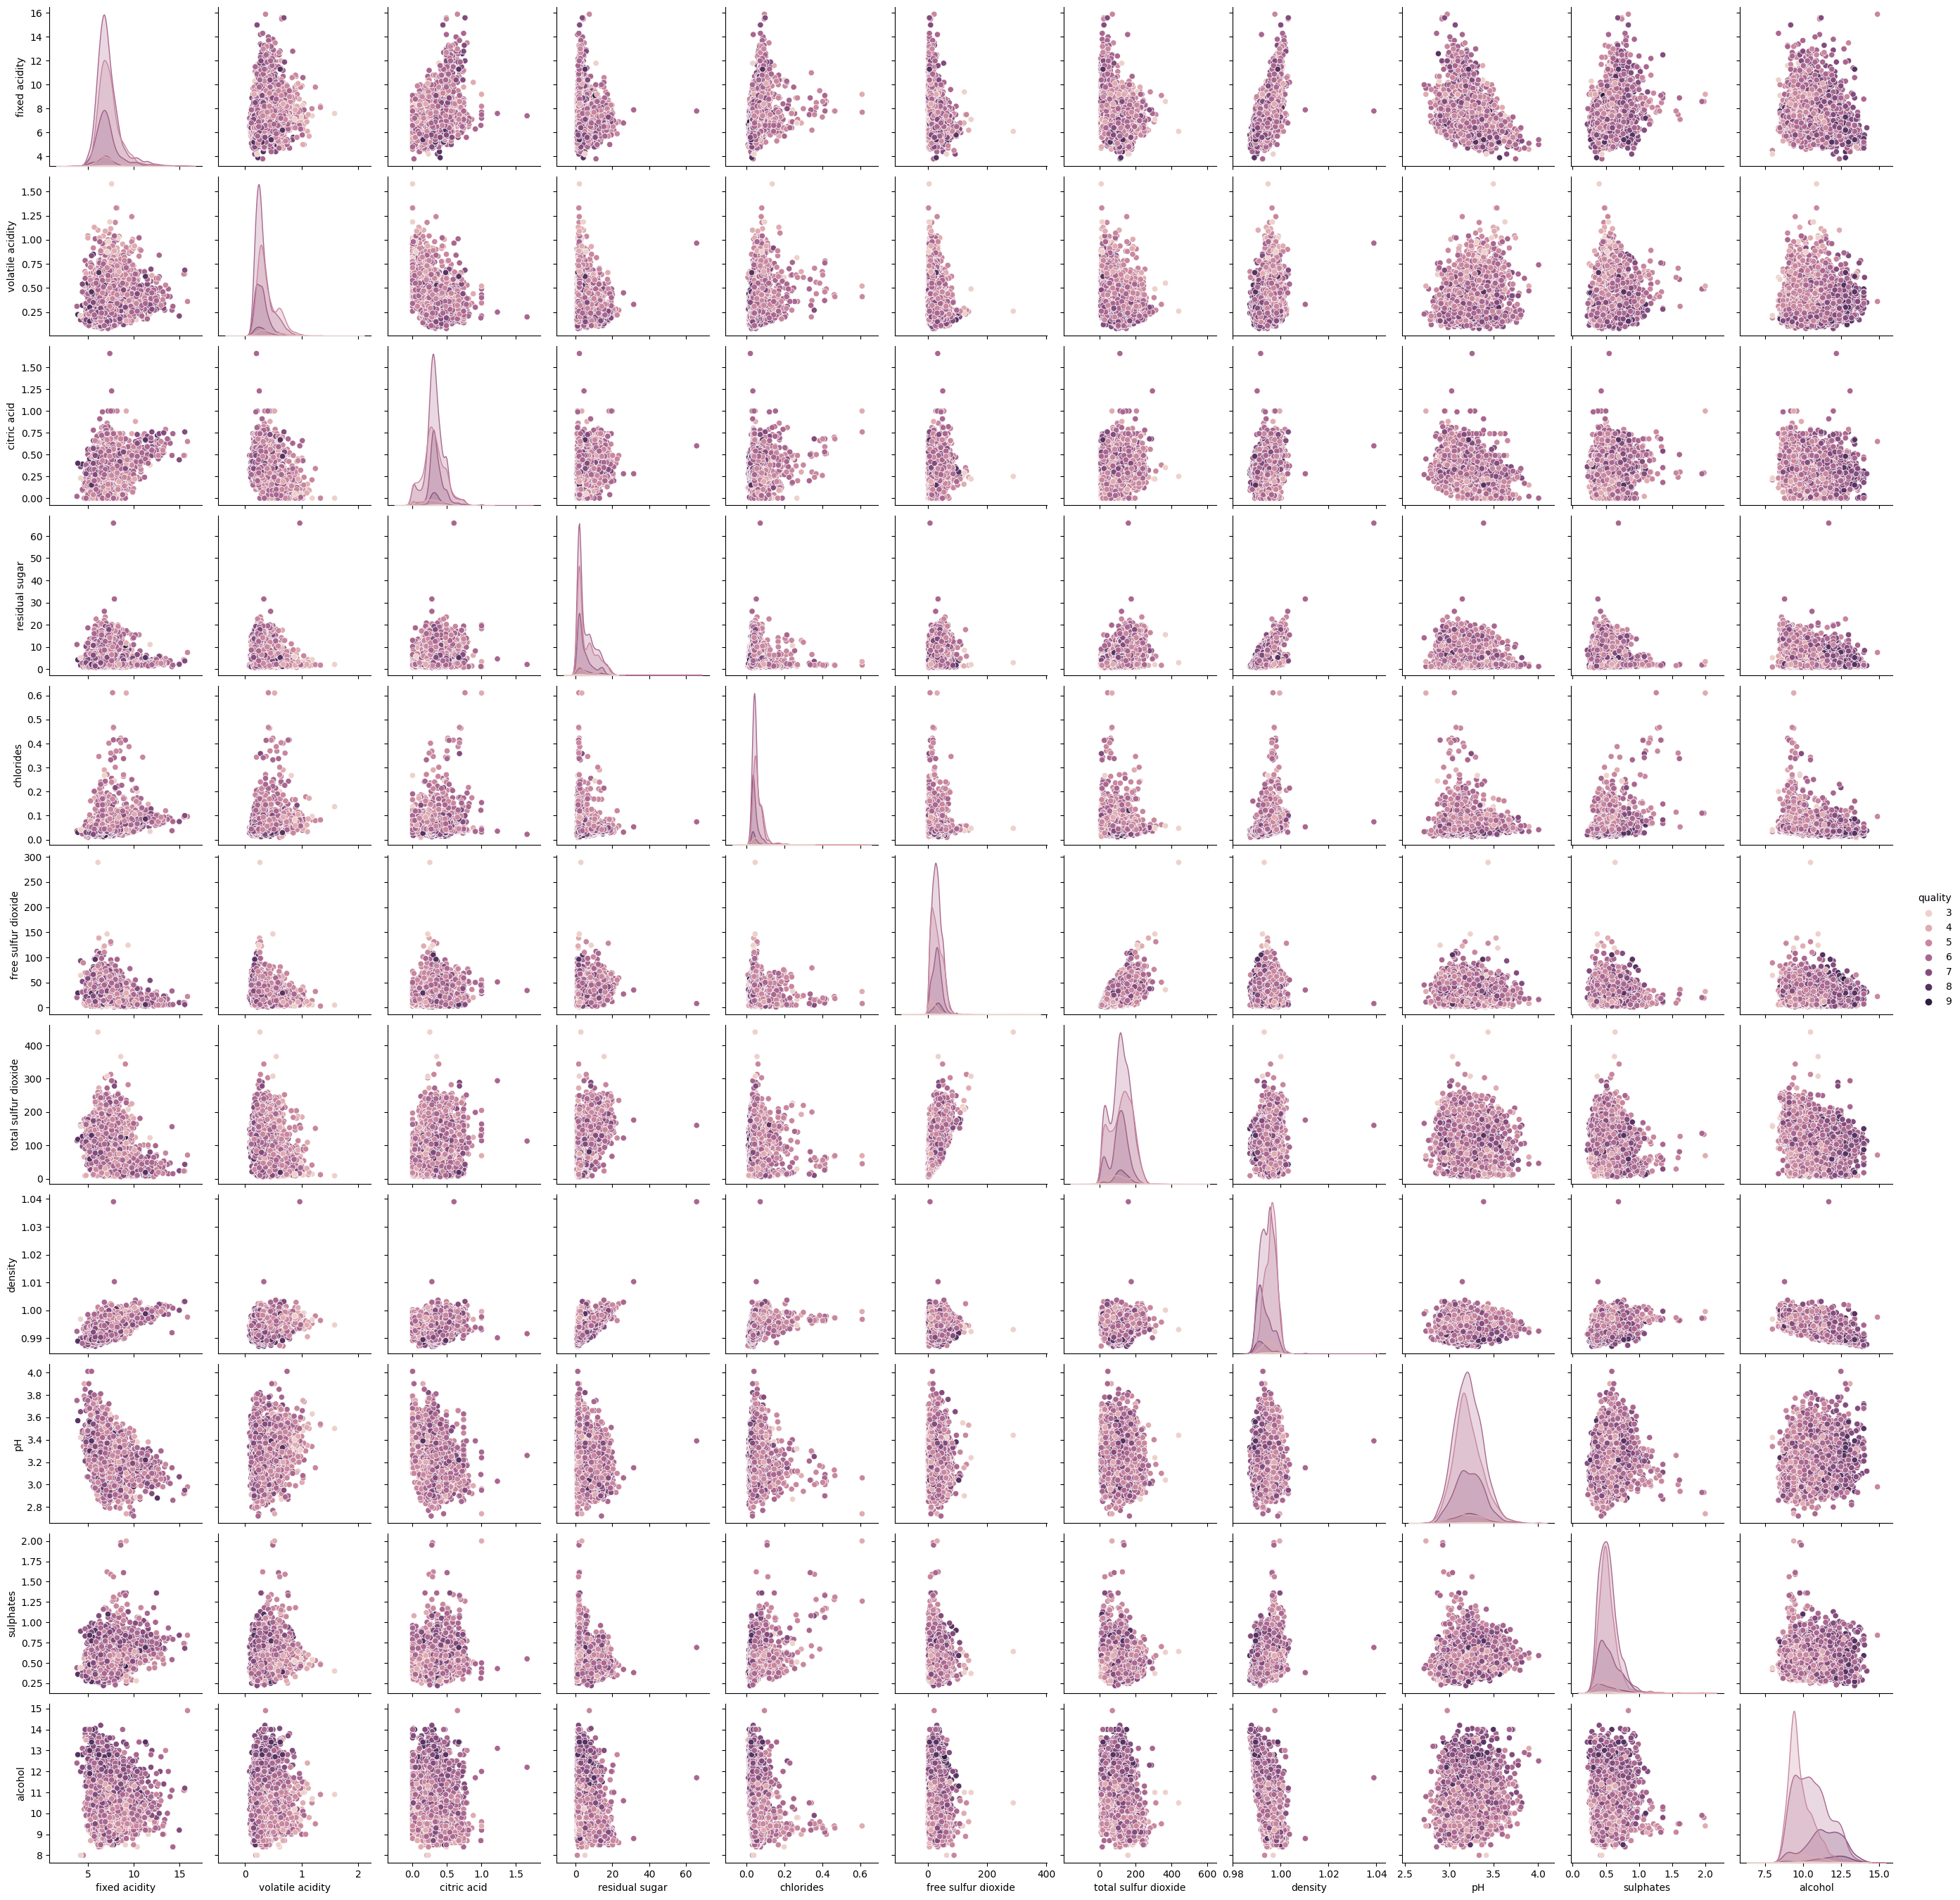

In [54]:
sns.pairplot(df, hue='quality')

distribuciones buenas, un poco a la izq (podemos hacer log para normalizar)

<Axes: xlabel='quality', ylabel='count'>

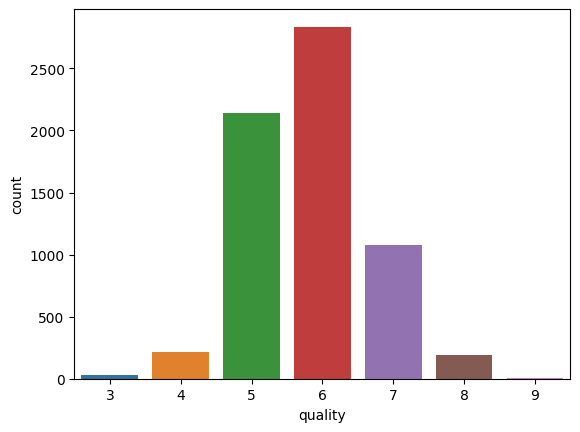

In [55]:
sns.countplot(x='quality', data=df,)

<Axes: xlabel='class', ylabel='count'>

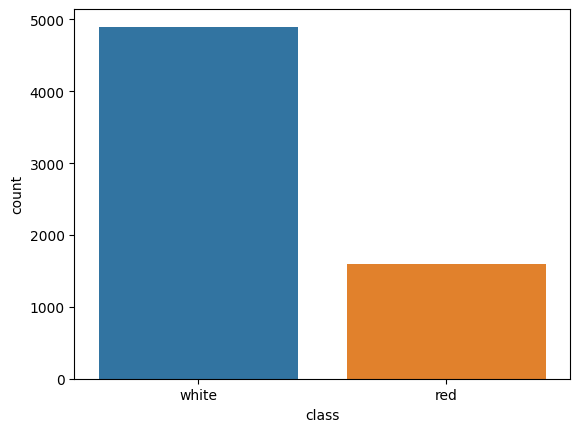

In [56]:
sns.countplot(x='class', data=df,)

Muy desequilibradas

<Axes: xlabel='alcohol', ylabel='Count'>

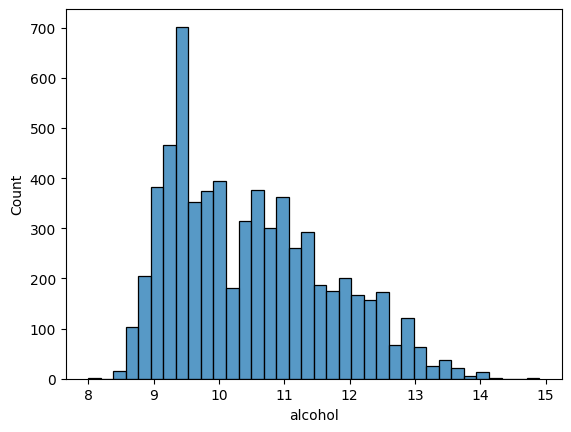

In [57]:
sns.histplot(df, x='alcohol', hue=)

<Axes: xlabel='quality', ylabel='count'>

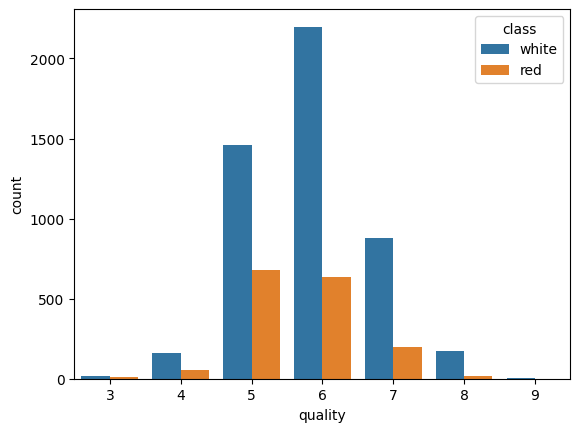

In [58]:
sns.countplot(x='quality',hue='class', data=df)

<Axes: xlabel='quality', ylabel='count'>

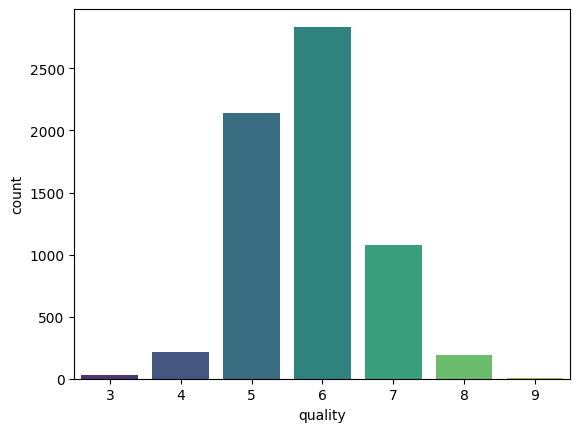

In [59]:
sns.countplot(data=df, x='quality', palette='viridis')

# COMO PONGO EN %???

array([[<Axes: title={'center': 'fixed acidity'}>,
        <Axes: title={'center': 'volatile acidity'}>,
        <Axes: title={'center': 'citric acid'}>],
       [<Axes: title={'center': 'residual sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free sulfur dioxide'}>],
       [<Axes: title={'center': 'total sulfur dioxide'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'pH'}>],
       [<Axes: title={'center': 'sulphates'}>,
        <Axes: title={'center': 'alcohol'}>, <Axes: >]], dtype=object)

<Figure size 1000x1000 with 0 Axes>

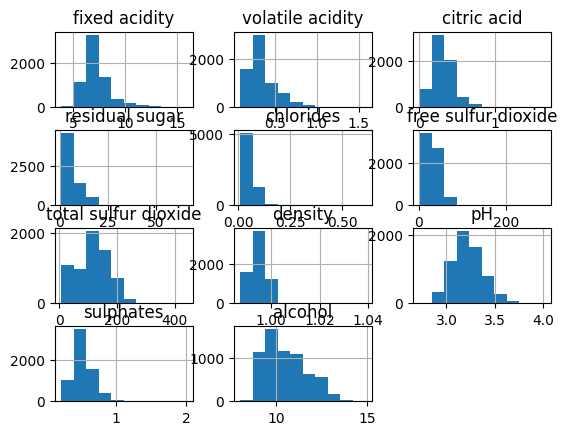

In [60]:
plt.figure(figsize=(10,10))

df.drop(columns=['class', 'quality']).hist()

<Axes: >

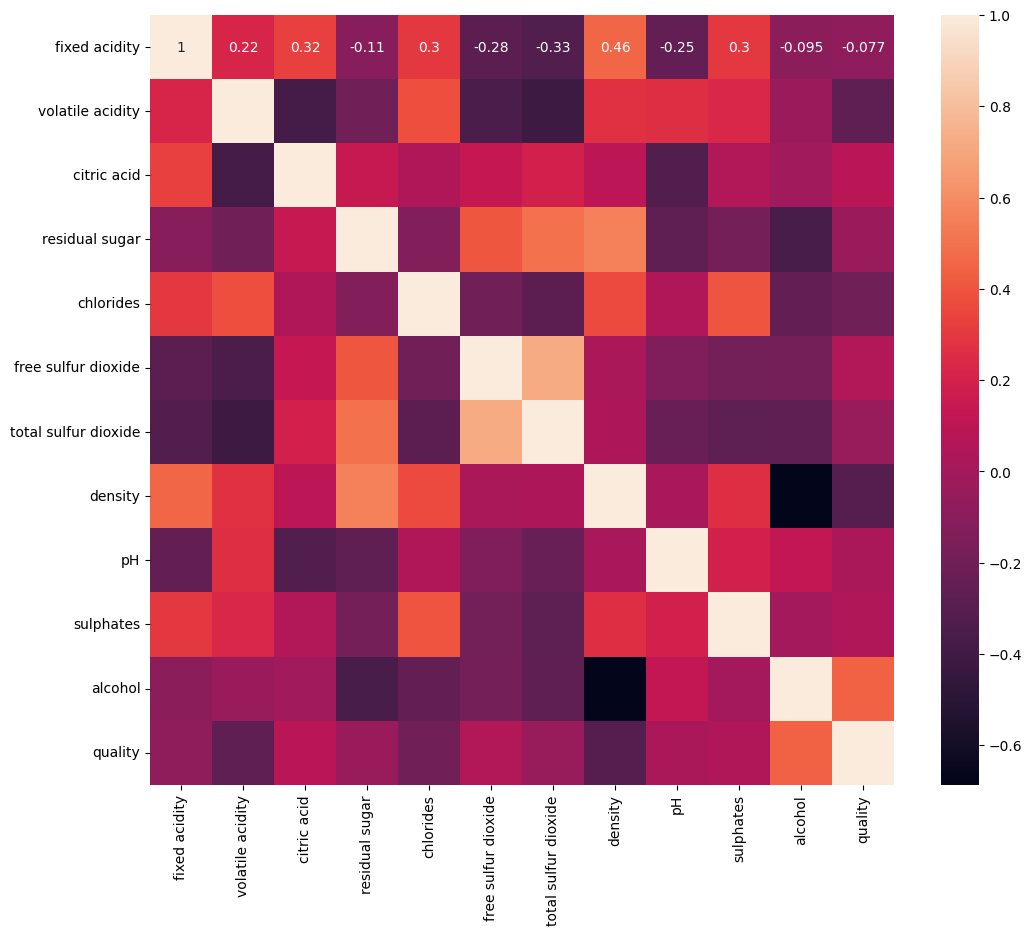

In [62]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Densidad y alcohol muy correlacionados

Quality y alcohol están bastante correlacionados. También es importante densidad para quality

2. ## DIVISIÓN DE DATOS 
No vale la misma para los dos modelos, ya que la target no es la misma. 


In [119]:
# train, test = train_test_split(df, train_size=0.8, random_state=42) #es necesario?
# X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train.drop(columns='quality'), test['quality'], test_size=0.2, random_state=42)

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros. El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora.

In [126]:
df_clas = df.copy()
# df_clas['citric acid'] = df_clas['citric acid']+1
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_clas.drop(columns='quality'), df_clas[['quality']], test_size=0.2, random_state=42)

**FEATURE ENGINEER**
Escalado y normalización.

Logaritmo a todas las columnas numéricas menos la target, que tiene distribución normal.
Escalado a todas
Balancear class


In [127]:
df_clas.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'class'],
      dtype='object')

In [128]:
col_log = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
col_std = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [129]:
X_train_log = X_train_1.copy()
X_test_log = X_test_1.copy()

# Aplicando Log
X_train_log[col_log] = np.log(X_train_1[col_log]+1)
X_test_log[col_log] = np.log(X_test_1[col_log]+1)

In [130]:
# # Aplicando StandardScaler
mms = MinMaxScaler()
X_train_mms = pd.DataFrame(mms.fit_transform(X_train_log[col_std]), columns=col_std, index=X_train_log.index)
X_test_mms = pd.DataFrame(mms.transform(X_test_log[col_std]), columns=col_std, index=X_test_log.index) #SOLO TRANSFORM

In [131]:
X_train_mms[['class']] = X_train_1[['class']]
X_train_mms.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1916       0.491561          0.115168     0.343926        0.185746   0.077235   
947        0.413984          0.115168     0.566156        0.626899   0.066959   
877        0.463319          0.435877     0.219877        0.085337   0.058702   
2927       0.293771          0.190117     0.252329        0.453766   0.085421   
6063       0.587542          0.318793     0.351202        0.201992   0.185202   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
1916             0.596860              0.548763  0.173230  0.510036   
947              0.625614              0.779661  0.243160  0.548600   
877              0.342544              0.653623  0.095382  0.285488   
2927             0.591641              0.710679  0.151643  0.293771   
6063             0.251724              0.109093  0.174008  0.351191   

      sulphates   alcohol  class  
1916   0.513586  0.607552    red  
947    0.351565  0.204920  white  
877    0.062471  0.526837  white  
2927   0.231352  0.281203  white  
6063   0.289533  0.700185    red

In [132]:
# Class --> ONEHOTENCODER/LABEL
#Replace  red y white por 0 y 1 
# cómo se balancea?

X_train_mms['class'] = X_train_mms['class'].replace({'white': 0, 'red': 1})

TRANSFORMACIONES DE JUAN


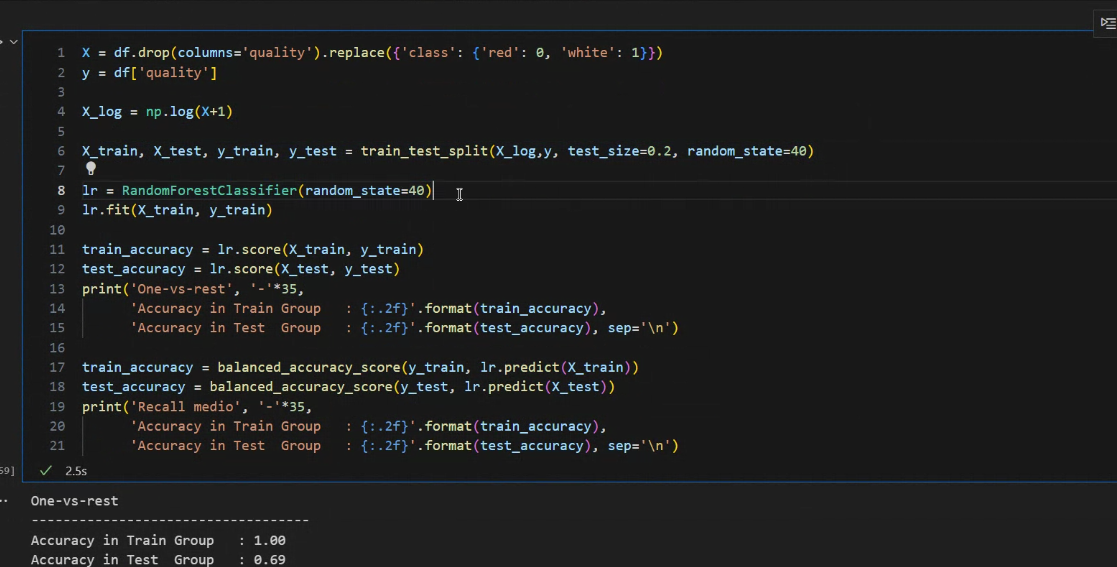



**PROBAMOS MODELOS**

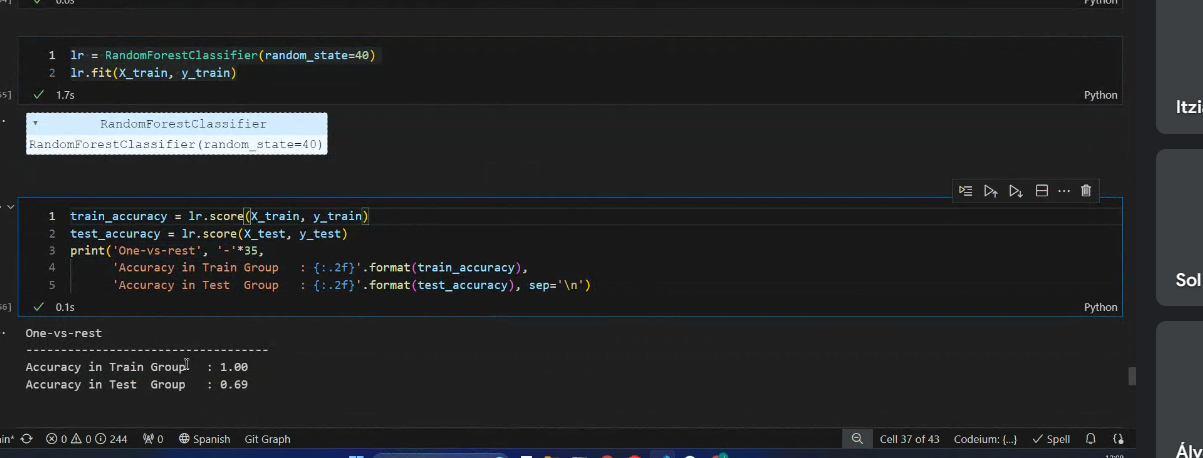

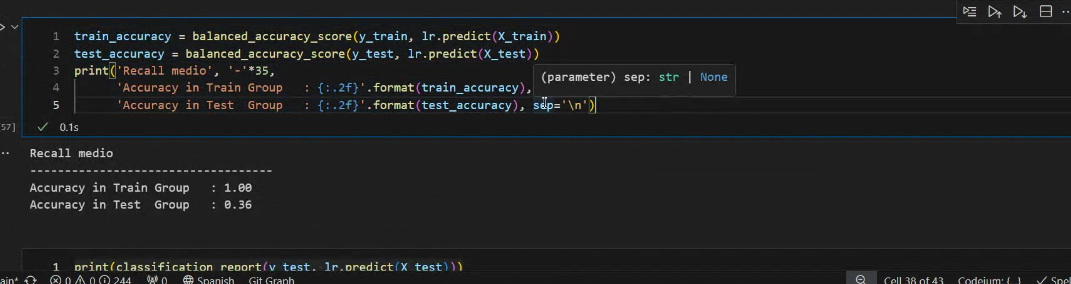


ESTE MODELO, AL PROBAR CON TEST, DA OVERFITTING

In [136]:
modelos = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    "SVC_linear": SVC(kernel='linear'),
    "SVC_poly": SVC(kernel='poly',degree=4),
    "SVC_rbf": SVC(), 
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(), 
    'GradientBoostingClassifier': HistGradienteBoostingClassifier(),
    'AdaboostClassifier' :AdaboostClassifier(), 
    'CatBoost': CatBoostClassifier(verbose = False)
}
resultados = {}

for modelo in modelos:
    resultados[modelo]=[cross_val_score(modelos[modelo], X_train_mms, y_train_1, cv=3, scoring="balanced_accuracy").mean()]



MODELOS QUE USA JUAN
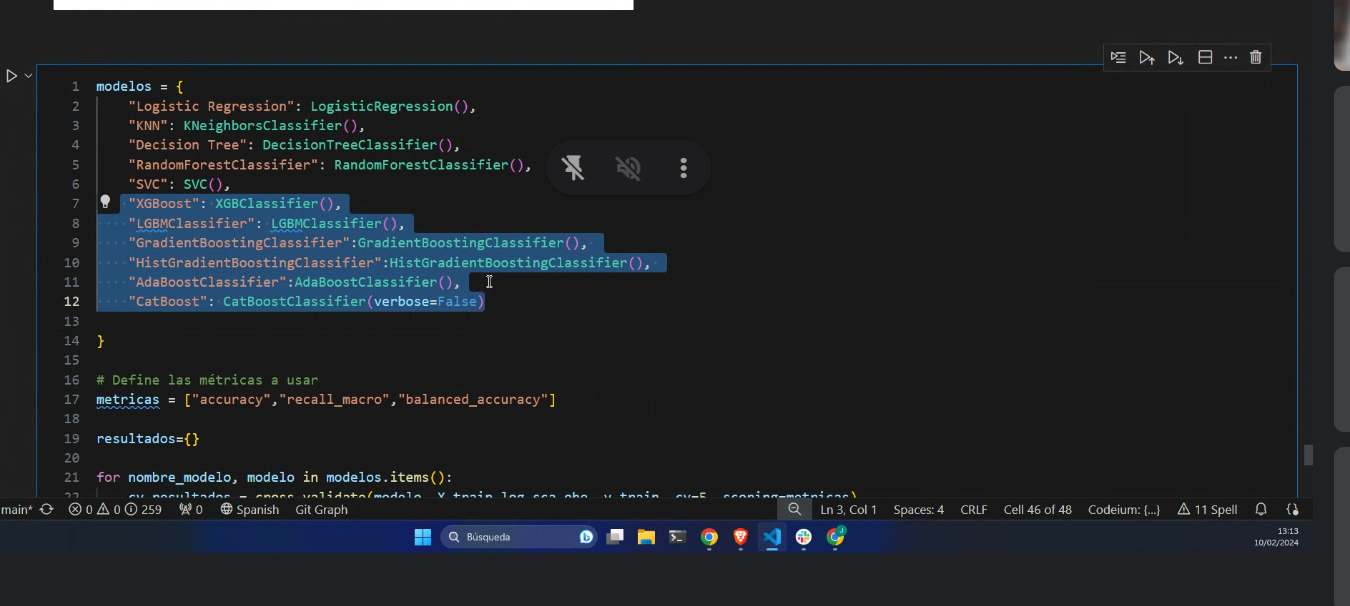

In [137]:
pd.DataFrame(resultados).T.sort_values(by=0, ascending=False)

0
RandomForest        0.322655
SVC_poly            0.232496
LogisticRegression  0.217728
SVC_rbf             0.211907
SVC_linear          0.196314

In [138]:
rdm_forest = RandomForestClassifier()
rdm_forest.fit(X_train_mms, y_train_1)


RandomForestClassifier()

In [139]:
y_pred_train = rdm_forest.predict(X_train_mms)
print(classification_report(y_train_1, y_pred_train))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00       173
           5       1.00      1.00      1.00      1706
           6       1.00      1.00      1.00      2274
           7       1.00      1.00      1.00       869
           8       1.00      1.00      1.00       146
           9       1.00      1.00      1.00         5

    accuracy                           1.00      5197
   macro avg       1.00      1.00      1.00      5197
weighted avg       1.00      1.00      1.00      5197



OVERFITTING

In [140]:
svc_poly = SVC(kernel='poly',degree=4)
svc_poly.fit(X_train_mms, y_train_1)

SVC(degree=4, kernel='poly')

In [141]:
y_pred_train = svc_poly.predict(X_train_mms)
print(classification_report(y_train_1, y_pred_train))

              precision    recall  f1-score   support

           3       1.00      0.50      0.67        24
           4       0.69      0.06      0.12       173
           5       0.66      0.66      0.66      1706
           6       0.57      0.77      0.65      2274
           7       0.62      0.28      0.39       869
           8       1.00      0.04      0.08       146
           9       0.00      0.00      0.00         5

    accuracy                           0.60      5197
   macro avg       0.65      0.33      0.37      5197
weighted avg       0.62      0.60      0.58      5197



### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara los modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros. Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

In [13]:
df_reg = df.copy()

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_clas.drop(columns='species'), df_clas['species'], test_size=0.2, random_state=42)